이 노트북은 [케라스 창시자에게 배우는 딥러닝 2판](https://tensorflow.blog/kerasdl2/)의 예제 코드를 담고 있습니다.

<table align="left">
    <tr>
        <td>
            <a href="https://colab.research.google.com/github/rickiepark/deep-learning-with-python-2nd/blob/main/chapter12_part04_variational-autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
        </td>
    </tr>
</table>

## 변이형 오토인코더를 사용한 이미지 생성

### AE - 오토인코더
위의 이야기는 오토인코더에 대한 비유이다. AE는 인코더와 디코더로 이뤄진 신경망이다:
- 인코더: 고차원의 입력(학습) 데이터를 저차원의 **표현 벡터**(잠재 공간)로 압축한다.
- 디코더: 주어진 (임의의) 표현 벡터를 원본 차원으로 압축 해제한다.

![Figure 3-4. Diagram of an autoencoder](https://i.imgur.com/gFU7d64.png)

원본 입력은 인코더와 디코더를 지나 재구성 이미지를 출력한다. 원본과 재구성 간의 차이를 최소화하는 방법으로 인코더와 디코더의 가중치가 훈련된다.

표현벡터는 원본 이미지를 저차원의 **잠재공간**으로 압축한 것이다. 잠재 공간의 임의 포인트는 디코더를 통해 원본 이미지 공간에서 **새로운 이미지**로 표현될 수 있다.

![Figure 3-3. The new generative art exhibition](https://i.imgur.com/hpcO8Cf.png)

### 이미지의 잠재 공간에서 샘플링하기
AE에서는 각 이미지가 잠재공간의 한 포인트에 직접 매핑된다. 반면, VAE에서는 이미지가 잠재공간에서의 한 점을 중심으로 한 정규분포에 매핑된다.
![](https://i.imgur.com/1p1jofm.png)

$${\displaystyle f_{\mathbf {X} }(x_{1},\ldots ,x_{k})={\frac {\exp \left(-{\frac {1}{2}}({\mathbf {x} }-{\boldsymbol {\mu }})^{\mathrm {T} }{\boldsymbol {\Sigma }}^{-1}({\mathbf {x} }-{\boldsymbol {\mu }})\right)}{\sqrt {(2\pi )^{k}|{\boldsymbol {\Sigma }}|}}}}
$$
for Bivariate case:
$${\boldsymbol  \mu }={\begin{pmatrix}\mu _{X}\\\mu _{Y}\end{pmatrix}},\quad {\boldsymbol  \Sigma }={\begin{pmatrix}\sigma _{X}^{2}&\rho \sigma _{X}\sigma _{Y}\\\rho \sigma _{X}\sigma _{Y}&\sigma _{Y}^{2}\end{pmatrix}}.$$
- $\rho$ is the correlation between $X$ and $Y$
- $\sigma _{X}>0$ and $\sigma _{Y}>0$.

---
VAE는 잠재공간의 각 차원 간에는 상관관계가 없다고 가정한다. 따라서:
- $\rho=0$ 이므로, 공분산 행렬(${\boldsymbol  \Sigma }$)은 대각행렬이 되고
- 이는 인코더가 입력 이미지르 평균 벡터(${\boldsymbol  \mu }$)와 분산 벡터(${\boldsymbol  \sigma^2 }$)만 매핑하면 된다는 것이다.
- 신경망의 출력은 $(-\infty, \infty)$이지만, 분산은 양수이므로, $\log {\boldsymbol  \sigma^2 }$를 매핑하겠다.

이제 인코더는 입력 이미지를 받아, 잠재공간의 다변량 정규분포를 정의하는 2개의 벡터 ${\boldsymbol  \mu }$, $\log {\boldsymbol  \sigma^2 }$를 인코딩한다.
 

---
최종적으로 다음과 같은 샘플링을 실시한 값으로 인코딩을 완료한다:
$${\boldsymbol z} = {\boldsymbol  \mu } + {\boldsymbol  \sigma} * {\boldsymbol \epsilon}$$
- ${\boldsymbol \sigma} = \exp{[(\log {\boldsymbol \sigma^2}) / 2]}$ : 2로 나누는 이유는 표준편차를 구하기 때문.
- ${\boldsymbol \epsilon} \sim {\boldsymbol N(0, 1)}$: z_dim 차원의 표준 정규분포로 부터 샘플링된 값.

### 이미지 변형을 위한 개념 벡터

### 변이형 오토인코더

### 케라스로 VAE 구현하기

**VAE 인코더 네트워크**

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [2]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

**잠재 공간 샘플링 층**

In [3]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

**잠재 공간 포인트를 이미지로 매핑하는 VAE 디코더 네트워크**

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [5]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

**사용자 정의 `train_step()` 메서드를 사용하는 VAE 모델**

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

**VAE 훈련**

In [7]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=30, batch_size=128)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 210s 383ms/step - total_loss: 209.3003 - reconstruction_loss: 206.6310 - kl_loss: 2.6694
Epoch 2/30
547/547 [==============================] - 189s 346ms/step - total_loss: 185.6888 - reconstruction_loss: 183.3624 - kl_loss: 2.3265
Epoch 3/30
547/547 [==============================] - 191s 349ms/step - total_loss: 175.3122 - reconstruction_loss: 172.2580 - kl_loss: 3.0540
Epoch 4/30
547/547 [==============================] - 190s 347ms/step - total_loss: 160.9246 - reconstruction_loss: 157.0394 - kl_loss: 3.8852
Epoch 5/30
547/547 [==============================] - 188s 344ms/step - total_loss: 157.1889 - reconstruction_loss: 153.2492 - kl_loss: 3.9398
Epoch 6/30
547/547 [==============================] - 185s 339ms/step - total_loss: 155.4143 - reconstruction_loss: 151.4661 - kl_loss: 3.9482
Epoch 7/30
547/547 [==============================] - 187s 342ms/step - total

**잠재 공간에서 이미지 그리드를 샘플링하기**

1/1 [==============================] - 0s 18ms/step


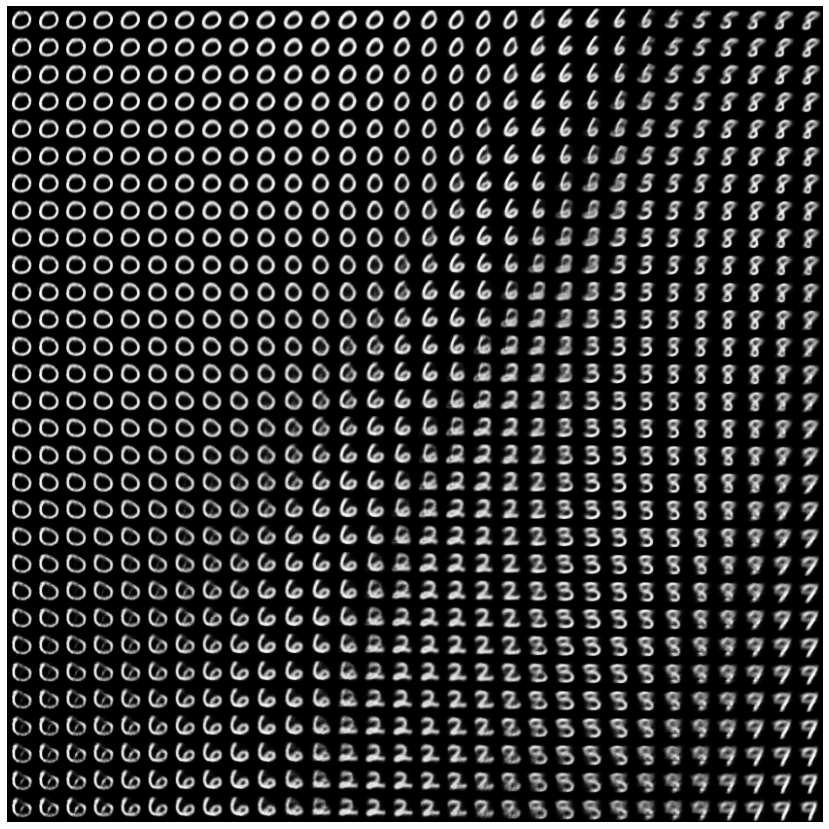

In [8]:
import matplotlib.pyplot as plt

n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")
plt.show()

### 정리